In [1]:
import torch
import torch.nn.functional as F
import json
from datasets import load_dataset
from audio import build_delay_indices, apply_audio_delay
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import pad
from config import DiaConfig

def pad_attention_mask_4d(attention_mask, maxlen = 2048):
    maxlen_right = maxlen
    maxlen_bottom = maxlen
    attention_mask = [
        F.pad(
            attention_mask[i],
            (0, maxlen_right - attention_mask[i].shape[-2], 0, maxlen_bottom - attention_mask[i].shape[-1])) for i in range(
            len(attention_mask))]
    return torch.stack(attention_mask)

def pad_3d_2d(tensor, max_size, value):
    padded = [
        F.pad(tensor[i], (0, 0, 0, max_size - tensor[i].shape[0]), value = value) for i in range(len(tensor))
    ]
    return torch.stack(padded)

def pad_attention_mask(attention_mask, maxlen_right, maxlen_bottom):
    attention_mask = [
        F.pad(
            attention_mask[i],
            (0, maxlen_right - attention_mask[i].shape[1], 0, maxlen_bottom - attention_mask[i].shape[0])) for i in range(
            len(attention_mask))]
    return torch.stack(attention_mask)

def block_diagonal_concat(*masks, dtype=torch.bool):
    total_size = sum(mask.size(0) for mask in masks)
    combined_mask = torch.zeros(total_size, total_size, dtype=dtype)

    current_pos = 0

    for mask in masks:
        size = mask.size(0)
        combined_mask[current_pos:current_pos + size, current_pos:current_pos + size] = mask
        current_pos += size

    return combined_mask

def block_diagonal_concat_cross(*masks, dtype=torch.bool):
    total_rows = sum(mask.size(0) for mask in masks)
    total_cols = sum(mask.size(1) for mask in masks)
    
    combined_mask = torch.zeros((total_rows, total_cols), dtype=dtype)
    
    current_row, current_col = 0, 0

    for mask in masks:
        rows, cols = mask.size()
        combined_mask[current_row:current_row + rows, current_col:current_col + cols] = mask
        current_row += rows
        current_col += cols
        
    return combined_mask

def new_path(f):
    return f.replace('_processed/', '_processed_trim_dac/').replace('.mp3', '.dac')

In [2]:
config = DiaConfig.load('config.json')

In [3]:
dataset = load_dataset('mesolitica/Malaysian-Emilia-Sesame')['train']

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
with open('merged-dia-4096.json') as fopen:
    merged = json.load(fopen)

In [5]:
codebook_size = 9
pad_tok = config.data.text_pad_value
pad_val = config.data.audio_pad_value
bos_val = config.data.audio_bos_value
eos_val = config.data.audio_eos_value

In [72]:
class DatasetFixed(torch.utils.data.Dataset):
    def __init__(
        self, 
        dataset,
        merged_file = None,
        calculated_speech_tokens = False,
    ):
        self.dataset = load_dataset(dataset)['train']
        self.length = len(self.dataset)
        self.merged = None

        if merged_file is not None:
            with open(merged_file) as fopen:
                self.merged = json.load(fopen)
            self.length = len(self.merged)

    def __getitem__(self, idx):
        if self.merged is None:
            indices = [self.dataset[idx]]
        else:
            indices = self.merged[idx]
        try:
            texts, encodings = [], []
            for idx in indices:
                data = self.dataset[idx]
                reference_audio = data['reference_audio'] 
                reference_text = data['reference_text']
                target_audio = data['target_audio']
                target_text = data['target_text']
                text = f'[S1] {reference_text}[S1] {target_text}'
                files = [reference_audio, target_audio]
                encodeds = []
                for f in files:
                    new_f = new_path(f)
                    with open(new_f) as fopen:
                        d = json.load(fopen)
                    d = torch.tensor(d)
                    if d.shape[1] != codebook_size:
                        d = d.T
                    encodeds.append(d)

                encoding = torch.concat(encodeds, dim = 0)
                texts.append(text)
                encodings.append(encoding)

            text_ids = []
            enc_self_attn_mask = []
            enc_lens = []
            src_pos = []

            for txt in texts:
                b_full = txt.encode('utf-8')
                arr = list(b_full)

                text_ids.append(torch.tensor(arr, dtype=torch.long))
                l = len(arr)
                enc_lens.append(l)
                enc_self_attn_mask.append(torch.ones(l, l).bool())
                src_pos.append(torch.arange(l))

            enc_self_attn_mask = block_diagonal_concat(*enc_self_attn_mask)

            tgts = []
            tgt_lens = []
            dec_self_attn_mask = []
            tgt_pos = []
            bos_tokens = torch.full([1, codebook_size], bos_val)
            for encoding in encodings:

                encoding = torch.concat([bos_tokens, encoding])
                ori_labels = encoding.T.tolist()
                delayed_ = []
                skip = 0
                for i in range(len(ori_labels)):
                    delayed_.append([bos_val] * skip + ori_labels[i] + [eos_val])
                    if i == 0:
                        skip += 8
                    else:
                        skip += 1
                maxlen = max([len(delayed_[i]) for i in range(len(ori_labels))])
                for i in range(len(ori_labels)):
                    delayed_[i] = delayed_[i] + [eos_val] * (maxlen - len(delayed_[i]))
                delayed_ = torch.tensor(delayed_).T
                L = len(delayed_)
                tgts.append(delayed_)
                tgt_lens.append(L)
                dec_self_attn_mask.append(torch.tril(torch.ones((L, L), dtype=torch.bool)))
                tgt_pos.append(torch.arange(L))

            dec_self_attn_mask = block_diagonal_concat(*dec_self_attn_mask)

            dec_cross_attn_mask = []
            for i in range(len(tgt_lens)):
                dec_cross_attn_mask.append(torch.ones(tgt_lens[i], enc_lens[i]).bool())

            dec_cross_attn_mask = block_diagonal_concat_cross(*dec_cross_attn_mask)

            text_ids = torch.concat(text_ids)
            src_pos = torch.concat(src_pos)
            tgt_pos = torch.concat(tgt_pos)
            tgt = torch.concat(tgts)
            return {
                'text_ids': text_ids,
                'src_pos': src_pos,
                'enc_self_attn_mask': enc_self_attn_mask,
                'tgt': tgt,
                'tgt_pos': tgt_pos,
                'dec_self_attn_mask': dec_self_attn_mask,
                'dec_cross_attn_mask': dec_cross_attn_mask,
                'encodings': encodings,
            }
        except Exception as e:
            print(e)

    def __len__(self):
        return self.length

In [73]:
dataset = DatasetFixed('mesolitica/Malaysian-Emilia-Sesame', 'merged-dia-4096.json')

In [74]:
batch = dataset[0]

In [77]:
batch['tgt'].shape

torch.Size([4083, 9])

In [23]:
encodings = batch['encodings']

In [94]:
encodings[0]

tensor([[ 330,  151,  272,  ...,   55,  824,  982],
        [ 330,  982,  719,  ...,  715, 1018,  430],
        [  35,  288,  491,  ...,   16,  906,  611],
        ...,
        [ 762,  634,  249,  ...,   16,  220,  708],
        [ 698,  848,  932,  ...,  166,  532,  746],
        [ 698,  778,  778,  ...,  772,  754,  925]])

In [25]:
batch['tgt'].shape

torch.Size([3918, 9])

In [27]:
encodings[0].shape

torch.Size([333, 9])

In [18]:
encodings[0].shape

torch.Size([333, 9])

In [69]:
torch.full([1, codebook_size], bos_val)

tensor([[1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026]])

In [70]:
tgts = []
tgt_lens = []
dec_self_attn_mask = []
tgt_pos = []
bos_tokens = torch.full([1, codebook_size], bos_val)
for encoding in encodings:
    
    encoding = torch.concat([bos_tokens, encoding])
    ori_labels = encoding.T.tolist()
    delayed_ = []
    skip = 0
    for i in range(len(ori_labels)):
        delayed_.append([bos_val] * skip + ori_labels[i] + [eos_val])
        if i == 0:
            skip += 8
        else:
            skip += 1
    maxlen = max([len(delayed_[i]) for i in range(len(ori_labels))])
    for i in range(len(ori_labels)):
        delayed_[i] = delayed_[i] + [eos_val] * (maxlen - len(delayed_[i]))
    delayed_ = torch.tensor(delayed_).T
    L = len(delayed_)
    tgts.append(delayed_)
    tgt_lens.append(L)
    dec_self_attn_mask.append(torch.tril(torch.ones((L, L), dtype=torch.bool)))
    tgt_pos.append(torch.arange(L))

In [101]:
delay_pattern = [
            0,
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15
        ]
max_delay_pattern = max(delay_pattern)

In [139]:
audio_prompts = [torch.randint(0, 10, size = (21, 9))]
batch_size = len(audio_prompts)
num_channels = config.data.channels
audio_bos_value = config.data.audio_bos_value
num_channels

9

In [140]:
max_len = max(p.shape[0] if p is not None else 0 for p in audio_prompts) + max_delay_pattern
prefill_steps = []

prefill = torch.full(
    (batch_size, max_len, num_channels),
    fill_value=-1,
    dtype=torch.int,
)

prefill[:, 0, :] = audio_bos_value

for i in range(batch_size):
    prompt = audio_prompts[i]
    if prompt is not None:
        prompt = prompt
        prefill[i, 1 : prompt.shape[0] + 1, :] = prompt
        prefill_steps.append(prompt.shape[0] + 1)
    else:
        prefill_steps.append(1)

delay_precomp = build_delay_indices(
    B=batch_size,
    T=max_len,
    C=num_channels,
    delay_pattern=delay_pattern,
)

delayed_batch = apply_audio_delay(
    audio_BxTxC=prefill,
    pad_value=-1,
    bos_value=audio_bos_value,
    precomp=delay_precomp,
)

In [141]:
delayed_batch.shape

torch.Size([1, 36, 9])

In [145]:
encoding

tensor([[1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   1,    0,    1,    1,    7,    4,    8,    2,    1],
        [   0,    1,    9,    7,    2,    9,    3,    7,    0],
        [   5,    0,    9,    8,    3,    8,    7,    9,    1],
        [   7,    0,    7,    4,    7,    1,    9,    1,    4],
        [   7,    4,    1,    9,    2,    5,    9,    9,    3],
        [   1,    9,    1,    4,    7,    1,    2,    5,    0],
        [   5,    8,    3,    6,    9,    2,    0,    1,    8],
        [   7,    0,    4,    0,    9,    9,    6,    9,    5],
        [   3,    1,    7,    3,    9,    9,    9,    9,    7],
        [   4,    6,    7,    8,    4,    1,    5,    7,    1],
        [   9,    3,    1,    8,    0,    5,    7,    0,    2],
        [   2,    3,    3,    8,    8,    4,    7,    4,    7],
        [   8,    0,    2,    1,    6,    4,    3,    3,    1],
        [   5,    0,    3,    0,    0,    3,    3,    0,    9],
        [   1,    9,    6,    3,    2,  

In [142]:
bos_tokens = torch.full([1, codebook_size], bos_val)
encoding = torch.concat([bos_tokens, audio_prompts[0]])
ori_labels = encoding.T.tolist()
delayed_ = []
skip = 0
for i in range(len(ori_labels)):
    delayed_.append([bos_val] * skip + ori_labels[i] + [eos_val])
    if i == 0:
        skip += 8
    else:
        skip += 1
maxlen = max([len(delayed_[i]) for i in range(len(ori_labels))])
for i in range(len(ori_labels)):
    delayed_[i] = delayed_[i] + [eos_val] * (maxlen - len(delayed_[i]))
delayed_ = torch.tensor(delayed_).T
delayed_

tensor([[1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   1, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   0, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   5, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   7, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   7, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   1, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   5, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   7, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   3,    0, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   4,    1,    1, 1026, 1026, 1026, 1026, 1026, 1026],
        [   9,    0,    9,    1, 1026, 1026, 1026, 1026, 1026],
        [   2,    0,    9,    7,    7, 1026, 1026, 1026, 1026],
        [   8,    4,    7,    8,    2,    4, 1026, 1026, 1026],
        [   5,    9,    1,    4,    3,    9,    8, 1026, 1026],
        [   1,    8,    1,    9,    7,  

In [143]:
delayed_batch[0]

tensor([[1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   1, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   0, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   5, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   7, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   7, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   1, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   5, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   7, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   3,    0, 1026, 1026, 1026, 1026, 1026, 1026, 1026],
        [   4,    1,    1, 1026, 1026, 1026, 1026, 1026, 1026],
        [   9,    0,    9,    1, 1026, 1026, 1026, 1026, 1026],
        [   2,    0,    9,    7,    7, 1026, 1026, 1026, 1026],
        [   8,    4,    7,    8,    2,    4, 1026, 1026, 1026],
        [   5,    9,    1,    4,    3,    9,    8, 1026, 1026],
        [   1,    8,    1,    9,    7,  

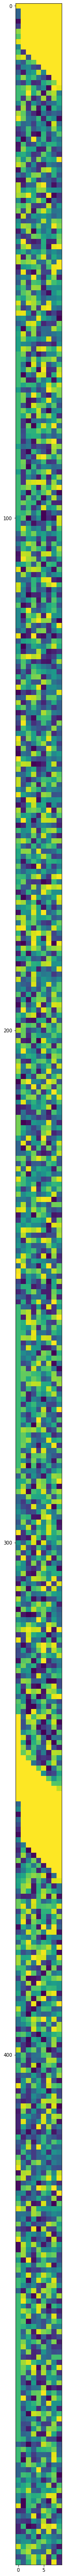

In [92]:
plt.figure(figsize=(5, 100))
plt.imshow(tgts.numpy()[:500])

In [44]:
dec_self_attn_mask = block_diagonal_concat(*dec_self_attn_mask)
dec_self_attn_mask

tensor([[ True, False, False,  ..., False, False, False],
        [ True,  True, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ...,  True,  True, False],
        [False, False, False,  ...,  True,  True,  True]])

In [54]:
import numpy as np
dec_self_attn_mask.numpy().astype(np.int32)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]], dtype=int32)

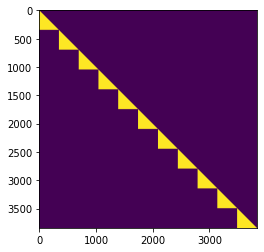

In [55]:
import matplotlib.pyplot as plt

plt.imshow(dec_self_attn_mask.numpy().astype(np.int32))